Epoch [45/50]
Generator Loss: 0.7978
Discriminator Loss: 1.3409


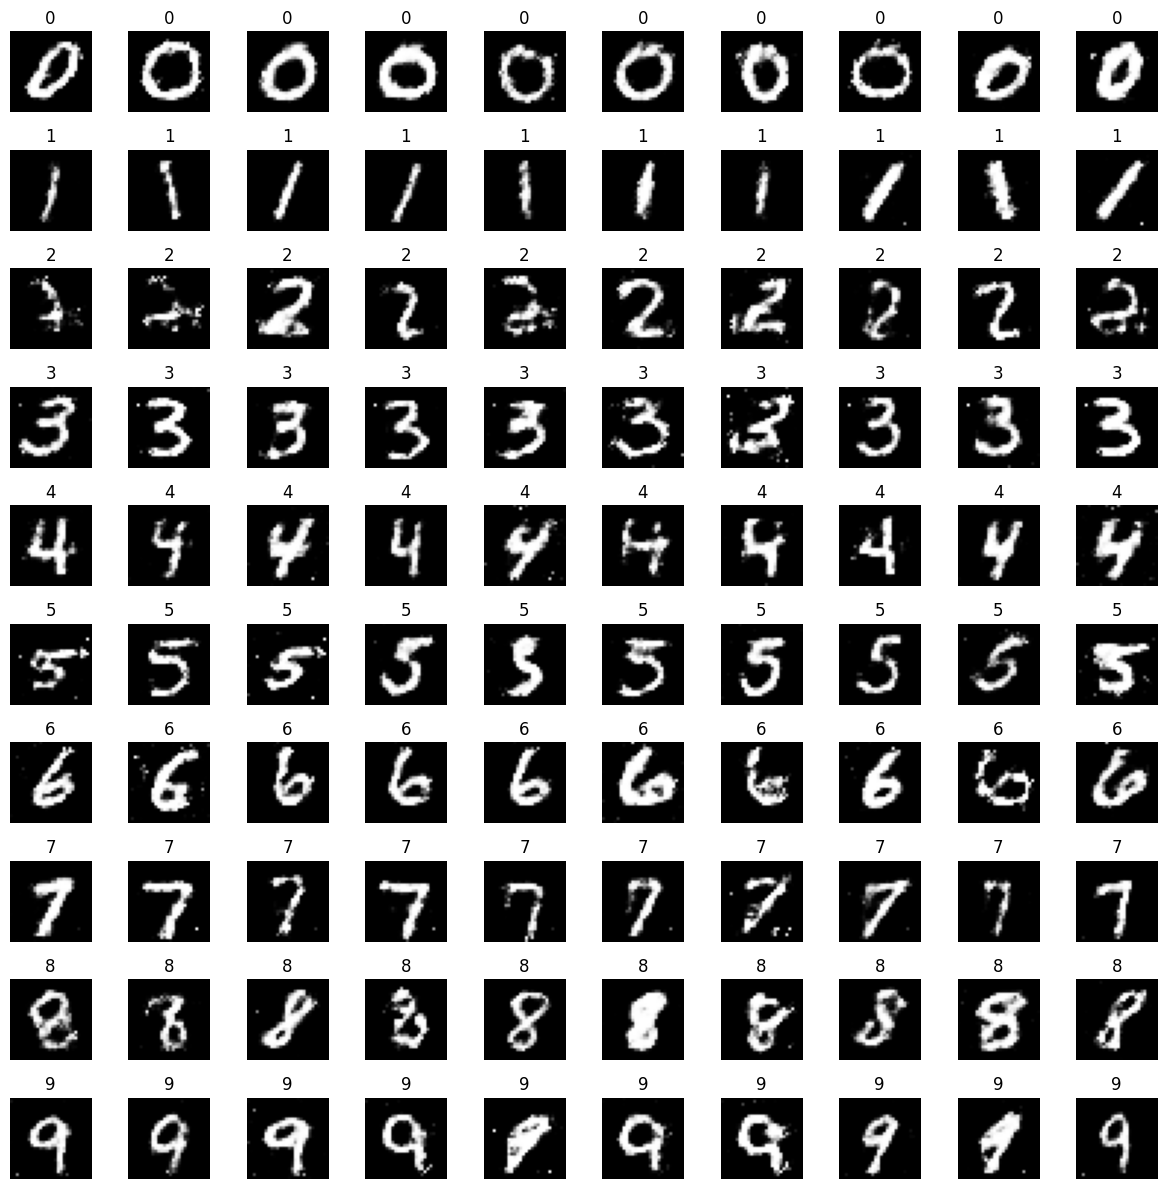

훈련 완료!

=== 텍스트에서 이미지 생성 테스트 ===
텍스트: 'zero' → 숫자: 0
텍스트: 'one' → 숫자: 1
텍스트: 'two' → 숫자: 2
텍스트: 'three' → 숫자: 3
텍스트: 'four' → 숫자: 4


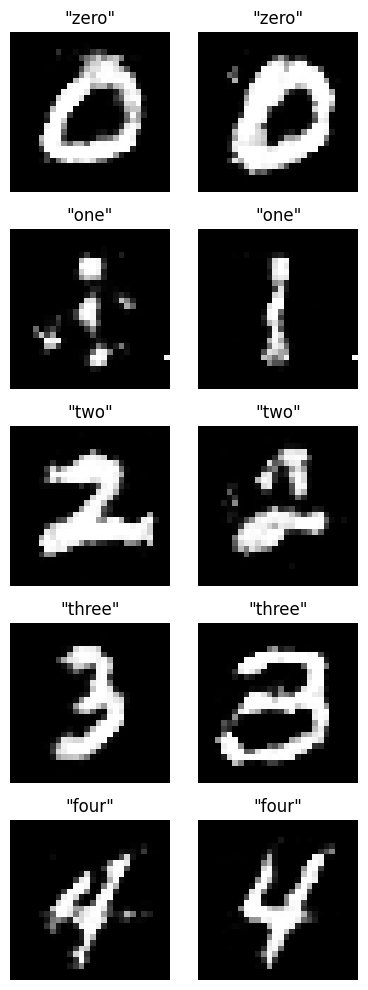

텍스트: '영' → 숫자: 0
텍스트: '일' → 숫자: 1
텍스트: '이' → 숫자: 2
텍스트: '삼' → 숫자: 3
텍스트: '사' → 숫자: 4


/tmp/ipython-input-3157143232.py:291: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3157143232.py:291: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3157143232.py:291: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3157143232.py:291: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3157143232.py:291: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarni

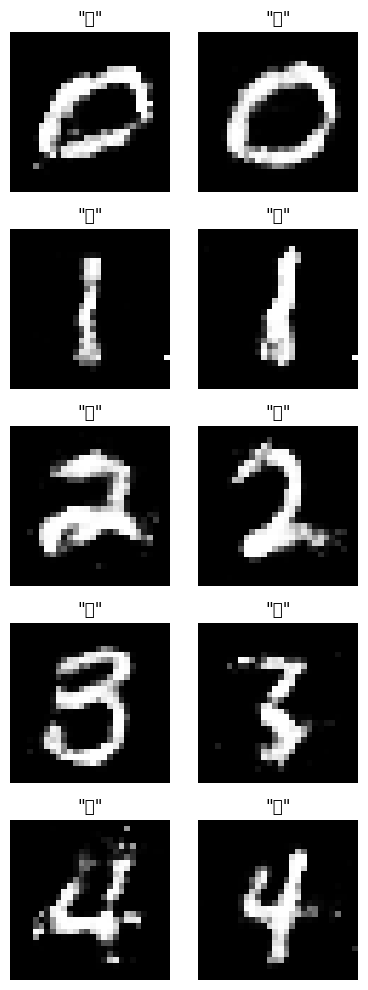

텍스트: '5' → 숫자: 5
텍스트: '6' → 숫자: 6
텍스트: '7' → 숫자: 7
텍스트: '8' → 숫자: 8
텍스트: '9' → 숫자: 9


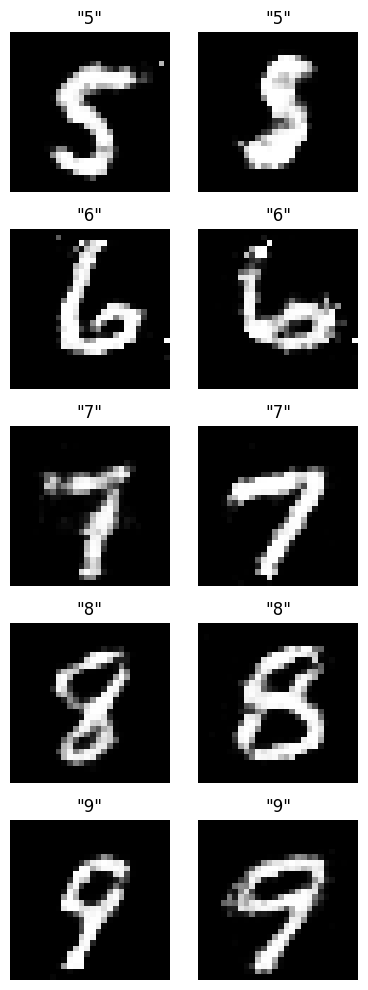

모든 테스트 완료!


In [1]:
# 텍스트 조건부 GAN - MNIST 숫자 생성
# Google Colab에서 실행 가능

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 중인 디바이스: {device}")

# 하이퍼파라미터
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
EPOCHS = 50
LATENT_DIM = 100
NUM_CLASSES = 10
EMBEDDING_DIM = 50

# 데이터 로더 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 생성자 네트워크
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim):
        super(Generator, self).__init__()

        # 클래스 임베딩 레이어 (텍스트 조건)
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # 메인 네트워크
        self.main = nn.Sequential(
            # 입력: latent_dim + embedding_dim
            nn.Linear(latent_dim + embedding_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # 라벨을 임베딩으로 변환
        label_embedding = self.label_embedding(labels)

        # 노이즈와 라벨 임베딩을 결합
        gen_input = torch.cat([noise, label_embedding], dim=1)

        # 이미지 생성
        img = self.main(gen_input)
        img = img.view(img.size(0), 1, 28, 28)

        return img

# 판별자 네트워크
class Discriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super(Discriminator, self).__init__()

        # 클래스 임베딩 레이어
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # 이미지 처리 네트워크
        self.main = nn.Sequential(
            # 입력: 28*28 + embedding_dim
            nn.Linear(28*28 + embedding_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # 이미지를 평면화
        img_flat = img.view(img.size(0), -1)

        # 라벨을 임베딩으로 변환
        label_embedding = self.label_embedding(labels)

        # 이미지와 라벨 임베딩을 결합
        disc_input = torch.cat([img_flat, label_embedding], dim=1)

        # 진짜/가짜 판별
        validity = self.main(disc_input)

        return validity

# 모델 초기화
generator = Generator(LATENT_DIM, NUM_CLASSES, EMBEDDING_DIM).to(device)
discriminator = Discriminator(NUM_CLASSES, EMBEDDING_DIM).to(device)

# 옵티마이저
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# 손실 함수
adversarial_loss = nn.BCELoss()

# 텍스트에서 숫자로 변환하는 함수
def text_to_digit(text_input):
    """텍스트 입력을 숫자로 변환"""
    text_to_num = {
        'zero': 0, '영': 0, '0': 0,
        'one': 1, '일': 1, '1': 1,
        'two': 2, '이': 2, '2': 2,
        'three': 3, '삼': 3, '3': 3,
        'four': 4, '사': 4, '4': 4,
        'five': 5, '오': 5, '5': 5,
        'six': 6, '육': 6, '6': 6,
        'seven': 7, '칠': 7, '7': 7,
        'eight': 8, '팔': 8, '8': 8,
        'nine': 9, '구': 9, '9': 9
    }

    text_input = text_input.lower().strip()
    return text_to_num.get(text_input, 0)

# 고정된 노이즈와 라벨 (시각화용)
fixed_noise = torch.randn(100, LATENT_DIM, device=device)
fixed_labels = torch.tensor([i for i in range(10) for _ in range(10)], device=device)

# 이미지 시각화 함수
def visualize_generated_images(generator, epoch, text_prompts=None):
    generator.eval()

    if text_prompts:
        # 텍스트 프롬프트에서 숫자 생성
        digits = [text_to_digit(prompt) for prompt in text_prompts]
        labels = torch.tensor(digits, device=device)
        noise = torch.randn(len(text_prompts), LATENT_DIM, device=device)

        with torch.no_grad():
            fake_images = generator(noise, labels)

        fig, axes = plt.subplots(1, len(text_prompts), figsize=(2*len(text_prompts), 2))
        if len(text_prompts) == 1:
            axes = [axes]

        for i, (prompt, img) in enumerate(zip(text_prompts, fake_images)):
            axes[i].imshow(img.cpu().squeeze().numpy(), cmap='gray')
            axes[i].set_title(f'"{prompt}" → {digits[i]}')
            axes[i].axis('off')
    else:
        # 고정된 샘플 생성
        with torch.no_grad():
            fake_images = generator(fixed_noise, fixed_labels)

        fig, axes = plt.subplots(10, 10, figsize=(12, 12))
        for i in range(100):
            row, col = i // 10, i % 10
            axes[row, col].imshow(fake_images[i].cpu().squeeze().numpy(), cmap='gray')
            axes[row, col].set_title(f'{fixed_labels[i].item()}')
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# 훈련 함수
def train_gan():
    print("조건부 GAN 훈련 시작...")

    for epoch in range(EPOCHS):
        epoch_g_loss = 0
        epoch_d_loss = 0

        for i, (real_images, real_labels) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = real_labels.to(device)

            # 진짜와 가짜 라벨
            real_label = torch.ones(batch_size, 1, device=device)
            fake_label = torch.zeros(batch_size, 1, device=device)

            # ==================== 판별자 훈련 ====================
            d_optimizer.zero_grad()

            # 진짜 이미지에 대한 손실
            real_output = discriminator(real_images, real_labels)
            d_real_loss = adversarial_loss(real_output, real_label)

            # 가짜 이미지 생성
            noise = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
            fake_images = generator(noise, fake_labels)

            # 가짜 이미지에 대한 손실
            fake_output = discriminator(fake_images.detach(), fake_labels)
            d_fake_loss = adversarial_loss(fake_output, fake_label)

            # 판별자 총 손실
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # ==================== 생성자 훈련 ====================
            g_optimizer.zero_grad()

            # 생성자는 판별자가 가짜 이미지를 진짜로 분류하도록 함
            fake_output = discriminator(fake_images, fake_labels)
            g_loss = adversarial_loss(fake_output, real_label)

            g_loss.backward()
            g_optimizer.step()

            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        # 에포크 정보 출력
        avg_g_loss = epoch_g_loss / len(train_loader)
        avg_d_loss = epoch_d_loss / len(train_loader)

        if epoch % 5 == 0:
            clear_output(wait=True)
            print(f"Epoch [{epoch}/{EPOCHS}]")
            print(f"Generator Loss: {avg_g_loss:.4f}")
            print(f"Discriminator Loss: {avg_d_loss:.4f}")

            # 생성된 이미지 시각화
            visualize_generated_images(generator, epoch)

    print("훈련 완료!")

# 텍스트 프롬프트로 이미지 생성하는 함수
def generate_from_text(text_prompts, num_samples=1):
    """텍스트 프롬프트에서 이미지 생성"""
    generator.eval()

    generated_images = []

    for prompt in text_prompts:
        digit = text_to_digit(prompt)
        print(f"텍스트: '{prompt}' → 숫자: {digit}")

        for _ in range(num_samples):
            noise = torch.randn(1, LATENT_DIM, device=device)
            label = torch.tensor([digit], device=device)

            with torch.no_grad():
                fake_image = generator(noise, label)
                generated_images.append((prompt, fake_image.cpu().squeeze().numpy()))

    # 결과 시각화
    fig, axes = plt.subplots(len(text_prompts), num_samples, figsize=(2*num_samples, 2*len(text_prompts)))
    if len(text_prompts) == 1 and num_samples == 1:
        axes = [[axes]]
    elif len(text_prompts) == 1:
        axes = [axes]
    elif num_samples == 1:
        axes = [[ax] for ax in axes]

    for i, prompt in enumerate(text_prompts):
        for j in range(num_samples):
            idx = i * num_samples + j
            axes[i][j].imshow(generated_images[idx][1], cmap='gray')
            axes[i][j].set_title(f'"{prompt}"')
            axes[i][j].axis('off')

    plt.tight_layout()
    plt.show()

# 실행 예시
if __name__ == "__main__":
    # 1. 모델 훈련
    train_gan()

    # 2. 텍스트에서 이미지 생성 테스트
    print("\n=== 텍스트에서 이미지 생성 테스트 ===")

    # 영어 숫자 이름으로 생성
    english_prompts = ["zero", "one", "two", "three", "four"]
    generate_from_text(english_prompts, num_samples=2)

    # 한글 숫자 이름으로 생성
    korean_prompts = ["영", "일", "이", "삼", "사"]
    generate_from_text(korean_prompts, num_samples=2)

    # 아라비아 숫자로 생성
    digit_prompts = ["5", "6", "7", "8", "9"]
    generate_from_text(digit_prompts, num_samples=2)

    print("모든 테스트 완료!")